## This notebook creates the machine learning models for both binary classification and regression tasks.


Import Libraries

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor

from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive # Import only if you are using Google Colab

Read in NBA stat data and add some features


In [ ]:
df_train = pd.read_csv('data/nba_stats_1980_2021.csv', sep = ',', decimal = '.')

In [ ]:
df_train['Wins'] = df_train.Overall.apply(lambda x: x.split('-')[0]).astype(int)
df_train['Losses'] = df_train.Overall.apply(lambda x: x.split('-')[1]).astype(int)
df_train['W/L%'] = df_train.Wins / (df_train.Wins + df_train.Losses)

df_train['GS%'] = df_train.GS / df_train.G
df_train['GP%'] = df_train.G / (df_train.Wins + df_train.Losses)

df_train['MVP Rank'] = df_train.groupby('Season')['Pts Won'].rank(ascending = False, method = 'dense')
df_train['Won MVP'] = np.where(df_train['MVP Rank'] == 1, 1, 0)

Read in NLU data

In [ ]:
nlu_data = pd.read_csv('data/nba_tweets_nlu_data.csv')

In [ ]:
nlu_cols = ['distilbert sadness', 'distilbert joy',
       'distilbert love', 'distilbert anger', 'distilbert fear',
       'distilbert surprise', 'pysent others', 'pysent joy', 'pysent sadness',
       'pysent anger', 'pysent surprise', 'pysent disgust', 'pysent fear',
       'pysent NEG', 'pysent NEU', 'pysent POS']
# averages all emotions by twitter username
meandf = (nlu_data.groupby(['player','season','tweet_username'])[nlu_cols].mean())


Getting Weighted Average of All NLU Scores for Player/Season


In [ ]:
# adds number of tweets by username (used for weighted average)
meandf = meandf.join(nlu_data.groupby(['player','season','tweet_username'])['tweet'].count())
meandf.reset_index(inplace=True)

In [ ]:
# gets weighted average for each player and season
weightdf =(meandf.groupby(['player','season']).apply(lambda x: (x[nlu_cols[0]] * x['tweet'].div(x['tweet'].sum())).sum())).to_frame(name=nlu_cols[0]).reset_index()
# adds weighted avearges for all emotions into one df
for col in nlu_cols[1:]:
  weightdf = pd.concat([weightdf, (meandf.groupby(['player','season']).apply(lambda x: (x[col] * x['tweet'].div(x['tweet'].sum())).sum())).to_frame(name=col).reset_index().drop(columns=['player','season'])], axis=1)



In [ ]:
# Adjust some player names and columns
weightdf.player = weightdf.player.str.replace('steph','Stephen')
weightdf.player = weightdf.player.str.replace('Stephenen','Stephen')
weightdf.season = weightdf.season.astype(str).str[5:].astype(np.int64)
weightdf.rename(columns={'player':'Player','season':'Season'},inplace=True)

Merge NLU data with Stats

In [ ]:
df_train = df_train.merge(weightdf, how= 'left',on= ['Player','Season'],suffixes=('', '_y'))
df_train.drop(df_train.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)


In [ ]:
df_train.tail()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,First,Pts Won,Pts Max,Share,Rk,Overall,Wins,Losses,W/L%,GS%,GP%,MVP Rank,Won MVP,distilbert sadness,distilbert joy,distilbert love,distilbert anger,distilbert fear,distilbert surprise,pysent others,pysent joy,pysent sadness,pysent anger,pysent surprise,pysent disgust,pysent fear,pysent NEG,pysent NEU,pysent POS
19732,Delon Wright,PG,28,SAC,27,8,25.8,3.9,8.3,0.462,1.2,3.1,0.398,2.6,5.3,0.500,0.536,1.1,1.3,0.833,1.0,2.9,3.9,3.6,1.6,0.4,1.3,1.1,10.0,2021,15.9,0.563,0.369,0.160,4.4,12.5,8.4,18.9,3.0,1.3,12.7,17.1,0.8,0.5,1.3,0.092,0.2,0.6,0.8,0.5,0,0,0,0.0,23,31-41,31,41,0.430556,0.296296,0.375000,13.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19733,Thaddeus Young,PF,32,CHI,68,23,24.3,5.4,9.7,0.559,0.2,0.7,0.267,5.3,9.1,0.580,0.568,1.0,1.7,0.628,2.5,3.8,6.2,4.3,1.1,0.6,2.0,2.2,12.1,2021,20.3,0.578,0.068,0.171,11.4,16.9,14.2,27.1,2.2,2.1,16.1,22.3,2.8,2.2,5.1,0.147,2.0,1.2,3.2,2.2,0,0,0,0.0,21,31-41,31,41,0.430556,0.338235,0.944444,13.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19734,Trae Young,PG,22,ATL,63,63,33.7,7.7,17.7,0.438,2.2,6.3,0.343,5.6,11.3,0.491,0.499,7.7,8.7,0.886,0.6,3.3,3.9,9.4,0.8,0.2,4.1,1.8,25.3,2021,23.0,0.589,0.357,0.491,2.0,10.5,6.3,45.5,1.2,0.5,16.2,33.0,5.9,1.3,7.2,0.163,5.4,-1.7,3.6,3.0,0,0,0,0.0,11,41-31,41,31,0.569444,1.000000,0.875000,13.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19735,Cody Zeller,C,28,CHO,48,21,20.9,3.8,6.8,0.559,0.1,0.6,0.143,3.7,6.2,0.598,0.565,1.8,2.5,0.714,2.5,4.4,6.8,1.8,0.6,0.4,1.1,2.5,9.4,2021,18.2,0.599,0.086,0.367,12.6,22.9,17.7,13.2,1.3,1.7,11.9,18.3,2.1,1.1,3.3,0.156,-0.2,-0.1,-0.3,0.4,0,0,0,0.0,19,33-39,33,39,0.458333,0.437500,0.666667,13.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19736,Ivica Zubac,C,23,LAC,72,33,22.3,3.6,5.5,0.652,0.0,0.1,0.250,3.6,5.4,0.656,0.654,1.9,2.4,0.789,2.6,4.6,7.2,1.3,0.3,0.9,1.1,2.6,9.0,2021,19.1,0.693,0.010,0.434,13.6,22.4,18.1,7.9,0.7,3.4,14.7,15.1,4.8,2.1,6.9,0.206,0.7,0.0,0.7,1.1,0,0,0,0.0,6,47-25,47,25,0.652778,0.458333,1.000000,13.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_train.Player.count()

19737

In [ ]:
# Isolating players who got any MVP votes
df_train_filtered = df_train[df_train['Pts Won'] > 0]
# renaming NLU cols
df_train_filtered.columns = df_train_filtered.columns.str.replace("distilbert ", "Dbert_")
df_train_filtered.columns = df_train_filtered.columns.str.replace("pysent ", "bert_")

# keep copy of filtered dataset
df_train_filtered_og = df_train_filtered.copy()

# Classification - Predict if Player is MVP or Not

Function for building training/test data


In [ ]:
def build_features(df_train, df_test):
    mms = MinMaxScaler()

    x_train_mms = mms.fit_transform(df_train[['ORB%', 'ORB', 'BLK%', 'FTr', 'Age', 'TOV%', '3P%', '3PAr', 'BLK', 'STL%', 'GS', 'TRB%',
                                              'STL', 'FG%', '3PA', 'DRB%', 'G', '3P', 'TRB', 'FT%', '2P%', 'AST', 'PF', 'MP',
                                              'eFG%', 'DRB', 'AST%', '2PA', 'TOV', 'TS%', '2P', 'FTA', 'FGA', 'USG%', 'DBPM', 'FT',
                                              'DWS', 'FG', 'PTS', 'Rk', 'OBPM', 'OWS', 'PER', 'BPM', 'WS/48', 'VORP', 'WS',
                                              'Wins', 'Losses', 'W/L%', 'GS%', 'GP%', 'bert_others', 'bert_joy', 'bert_sadness', 'bert_anger', 
                                              'bert_surprise', 'bert_disgust', 'bert_fear', 'bert_NEG','bert_NEU', 'bert_POS']])
    
    x_test_mms = mms.transform(df_test[['ORB%', 'ORB', 'BLK%', 'FTr', 'Age', 'TOV%', '3P%', '3PAr', 'BLK', 'STL%', 'GS', 'TRB%',
                                        'STL', 'FG%', '3PA', 'DRB%', 'G', '3P', 'TRB', 'FT%', '2P%', 'AST', 'PF', 'MP',
                                        'eFG%', 'DRB', 'AST%', '2PA', 'TOV', 'TS%', '2P', 'FTA', 'FGA', 'USG%', 'DBPM', 'FT',
                                        'DWS', 'FG', 'PTS', 'Rk', 'OBPM', 'OWS', 'PER', 'BPM', 'WS/48', 'VORP', 'WS',
                                        'Wins', 'Losses', 'W/L%', 'GS%', 'GP%', 'bert_others', 'bert_joy', 'bert_sadness', 'bert_anger', 
                                        'bert_surprise', 'bert_disgust', 'bert_fear', 'bert_NEG','bert_NEU', 'bert_POS']])
                                       

  
    x_train = np.hstack([x_train_mms])
    x_test = np.hstack([x_test_mms])

    y_train = df_train['Won MVP'].values.reshape(-1, 1)
    y_test = df_test['Won MVP'].values.reshape(-1, 1)

    return x_train, y_train, x_test, y_test

Model selection

In [ ]:
model = LogisticRegression(solver = 'liblinear')
#model = RandomForestClassifier(n_estimators=100)
#model = KNeighborsClassifier(n_neighbors=25, weights='distance')
#model = XGBClassifier(n_estimators=50)
#model = svm.SVC(probability=True, kernel='linear')
#model = GaussianNB()

Testing Models on Every Season

In [ ]:
df_train_predicted = []
df_train_filtered = df_train_filtered_og.copy()
df_train_filtered = df_train_filtered.fillna(df_train_filtered.median())

all_y_test = []
all_y_preds = []
results_matrix = np.zeros(shape = (1, 2021 - 1980, 4, 2))
for season in range(1980, 2022):
    fold = season - 1980 - 1
    df_train = df_train_filtered[df_train_filtered.Season != season]
    df_test = df_train_filtered[df_train_filtered.Season == season]
    x_train, y_train, x_test, y_test = build_features(df_train, df_test)

    model.fit(x_train, y_train)

    df_train_rank = df_train.copy()

    df_train_rank['MVP Odds'] = model.predict_proba(x_train)[:, 1]

    df_train_rank['Predicted MVP Rank'] = df_train_rank.groupby('Season')['MVP Odds'].rank(ascending = False, method = 'dense')

    df_train_rank['Predicted MVP Winner'] = df_train_rank['Predicted MVP Rank']
    df_train_rank['Predicted MVP Winner'].loc[df_train_rank['Predicted MVP Winner'] != 1] = 0

    df_train_rank_won_mvp = df_train_rank['Won MVP']
    df_train_rank_predicted_mvp_winner = df_train_rank['Predicted MVP Winner']

    results_matrix[0, fold, 0, 0] = metrics.accuracy_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)
    results_matrix[0, fold, 1, 0] = metrics.precision_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)
    results_matrix[0, fold, 2, 0] = metrics.recall_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)
    results_matrix[0, fold, 3, 0] = metrics.f1_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)

    df_test_rank = df_test.copy()

    y_proba = model.predict_proba(x_test)[:, 1]
    df_test_rank['MVP Odds'] = y_proba 

    df_train_predicted.append(df_test_rank)

    df_test_rank['Predicted MVP Rank'] = df_test_rank.groupby('Season')['MVP Odds'].rank(ascending = False, method = 'dense')

    df_test_rank['Predicted MVP Winner'] = df_test_rank['Predicted MVP Rank']
    df_test_rank['Predicted MVP Winner'].loc[df_test_rank['Predicted MVP Winner'] != 1] = 0

    df_test_rank_won_mvp = df_test_rank['Won MVP']
    df_test_rank_predicted_mvp_winner = df_test_rank['Predicted MVP Winner']

 
    results_matrix[0, fold, 0, 1] = metrics.accuracy_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
    results_matrix[0, fold, 1, 1] = metrics.precision_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
    results_matrix[0, fold, 2, 1] = metrics.recall_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
    results_matrix[0, fold, 3, 1] = metrics.f1_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
    
    all_y_test.append(y_test)
    all_y_preds.append(y_proba)
all_y_preds = np.concatenate( all_y_preds, axis=0 )
all_y_test = np.concatenate( all_y_test, axis=0 )

Evaluation Metrics

In [ ]:
print('Algorithm: Logistic Regression)
print()
print('Train')
print('Accuracy:', results_matrix[0, :, 0, 0].mean())
print('Precision:', results_matrix[0, :, 1, 0].mean())
print('Coverage:', results_matrix[0, :, 2, 0].mean())
print('F Measure:', results_matrix[0, :, 3, 0].mean())
print()
print('Test')
print('Accuracy:', results_matrix[0, :, 0, 1].mean())
print('Precision:', results_matrix[0, :, 1, 1].mean())
print('Coverage:', results_matrix[0, :, 2, 1].mean())
print('F Measure:', results_matrix[0, :, 3, 1].mean())
print('ROC AUC =', roc_auc_score(all_y_test, all_y_preds))

Algorithm: Logistic Regression - MinMax

Train
Accuracy: 0.9731672778310104
Precision: 0.7834622248661511
Coverage: 0.7834622248661511
F Measure: 0.7834622248661511

Test
Accuracy: 0.9633232585793403
Precision: 0.7073170731707317
Coverage: 0.7073170731707317
F Measure: 0.7073170731707317


Finding Feature Importance

In [ ]:
features = ['ORB%', 'ORB', 'BLK%', 'FTr', 'Age', 'TOV%', '3P%', '3PAr', 'BLK', 'STL%', 'GS', 'TRB%',
                                        'STL', 'FG%', '3PA', 'DRB%', 'G', '3P', 'TRB', 'FT%', '2P%', 'AST', 'PF', 'MP',
                                        'eFG%', 'DRB', 'AST%', '2PA', 'TOV', 'TS%', '2P', 'FTA', 'FGA', 'USG%', 'DBPM', 'FT',
                                        'DWS', 'FG', 'PTS', 'Rk', 'OBPM', 'OWS', 'PER', 'BPM', 'WS/48', 'VORP', 'WS',
                                        'Wins', 'Losses', 'W/L%', 'GS%', 'GP%','bert_others', 'bert_joy', 'bert_sadness', 'bert_anger', 
                                        'bert_surprise', 'bert_disgust', 'bert_fear', 'bert_NEG','bert_NEU', 'bert_POS']
importances =model.coef_[0]
indices = np.argsort(importances)
fig = plt.figure(figsize=(15, 15))

plt.title('Feature Importances Model With No Dbert')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()
plt.savefig('log_reg_classifier_importances_no_Dbert.png')

MVP Results

In [ ]:
df_train_predicted = pd.concat(df_train_predicted)

 Players that Won MVP that were not predicted to win


In [ ]:
df_train_predicted[(df_train_predicted['Won MVP'] == 1) & (df_train_predicted['Predicted MVP Winner'] != 1)][['Player', 'Season', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', 'WS', 'VORP', 'Overall',  'Predicted MVP Rank']]

,Player,Season,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,WS,VORP,Overall,Predicted MVP Rank
411,Julius Erving,1981,PHI,35.0,24.6,8.0,4.4,2.1,1.8,0.521,13.8,6.9,62-20,6.0
862,Moses Malone,1982,HOU,42.0,31.1,14.7,1.8,0.9,1.5,0.519,15.4,5.5,46-36,4.0
4803,Charles Barkley,1993,PHO,37.6,25.6,12.2,5.1,1.6,1.0,0.520,14.4,7.1,62-20,2.0
5501,Hakeem Olajuwon,1994,HOU,41.0,27.3,11.9,3.6,1.6,3.7,0.528,14.3,7.3,58-24,2.0
6828,Karl Malone,1997,UTA,36.6,27.4,9.9,4.5,1.4,0.6,0.550,16.7,7.7,64-18,2.0
7293,Michael Jordan,1998,CHI,38.8,28.7,5.8,3.5,1.7,0.5,0.465,15.8,7.1,62-20,2.0
8710,Allen Iverson,2001,PHI,42.0,31.1,3.8,4.6,2.5,0.3,0.420,11.8,6.1,56-26,4.0
10781,Steve Nash,2005,PHO,34.3,15.5,3.3,11.5,1.0,0.1,0.502,10.9,4.4,62-20,7.0
11294,Steve Nash,2006,PHO,35.4,18.8,4.2,10.5,0.8,0.2,0.512,12.4,4.9,54-28,8.0
12040,Kobe Bryant,2008,LAL,38.9,28.3,6.3,5.4,1.8,0.5,0.459,13.8,6.3,57-25,6.0


Corresponding Players that Model Predicted to Win

In [ ]:
df_train_predicted[(df_train_predicted['Won MVP'] != 1) & (df_train_predicted['Predicted MVP Winner'] == 1)][['Player', 'Season', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', 'WS', 'VORP', 'Overall', 'MVP Rank']]

,Player,Season,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,WS,VORP,Overall,MVP Rank
323,Kareem Abdul-Jabbar,1981,LAL,37.2,26.2,10.3,3.4,0.7,2.9,0.574,14.3,6.1,54-28,3.0
673,Larry Bird,1982,BOS,38.0,22.9,10.9,5.8,1.9,0.9,0.503,12.5,6.4,63-19,2.0
4964,Michael Jordan,1993,CHI,39.3,32.6,6.7,5.5,2.8,0.8,0.495,17.2,10.2,57-25,3.0
5542,David Robinson,1994,SAS,40.5,29.8,10.7,4.8,1.7,3.3,0.507,20.0,11.4,55-27,2.0
6786,Michael Jordan,1997,CHI,37.9,29.6,5.9,4.3,1.7,0.5,0.486,18.3,8.6,69-13,2.0
7327,Karl Malone,1998,UTA,37.4,27.0,10.3,3.9,1.2,0.9,0.530,16.4,7.1,62-20,2.0
8837,Shaquille O'Neal,2001,LAL,39.5,28.7,12.7,3.7,0.6,2.8,0.572,14.9,7.1,56-26,3.0
10788,Dirk Nowitzki,2005,DAL,38.7,26.1,9.7,3.1,1.2,1.5,0.459,15.6,7.1,58-24,3.0
11301,Dirk Nowitzki,2006,DAL,38.1,26.6,9.0,2.8,0.7,1.0,0.480,17.7,7.9,60-22,3.0
12339,Chris Paul,2008,NOH,37.6,21.1,4.0,11.6,2.7,0.1,0.488,17.8,9.3,56-26,2.0


Look at NLU Scores for Model's Incorrect Seasons - Predicted MVPs

In [ ]:
df_train_predicted_recent = df_train_predicted[df_train_predicted['Season'] > 2010]
df_train_predicted_recent[(df_train_predicted_recent['Won MVP'] != 1) & (df_train_predicted_recent['Predicted MVP Winner'] == 1)][['Player', 'Season', 'Tm', 'bert_others', 'bert_joy', 'bert_sadness',
       'bert_anger', 'bert_surprise', 'bert_disgust', 'bert_fear', 'bert_NEG',
 'bert_POS', 'Predicted MVP Rank']]

,Player,Season,Tm,bert_others,bert_joy,bert_sadness,bert_anger,bert_surprise,bert_disgust,bert_fear,bert_NEG,bert_POS,Predicted MVP Rank
13790,LeBron James,2011,MIA,0.866175,0.023478,0.002306,0.002543,0.016648,0.061585,0.027263,0.208260,0.079457,1.0
17041,Kawhi Leonard,2017,SAS,0.860065,0.102948,0.002736,0.001861,0.023651,0.004127,0.004613,0.110419,0.370980,1.0


Look at NLU Scores for Model's Incorrect Seasons - Actual MVPs

In [ ]:
df_train_predicted_recent[(df_train_predicted_recent['Won MVP'] == 1) & (df_train_predicted_recent['Predicted MVP Winner'] != 1)][['Player', 'Season', 'Tm', 'bert_others', 'bert_joy', 'bert_sadness',
       'bert_anger', 'bert_surprise', 'bert_disgust', 'bert_fear', 'bert_NEG',
 'bert_POS', 'Predicted MVP Rank']]

,Player,Season,Tm,bert_others,bert_joy,bert_sadness,bert_anger,bert_surprise,bert_disgust,bert_fear,bert_NEG,bert_POS,Predicted MVP Rank
13945,Derrick Rose,2011,CHI,0.857237,0.065821,0.003977,0.001897,0.065965,0.002767,0.002336,0.120431,0.272471,2.0
17260,Russell Westbrook,2017,OKC,0.795037,0.093736,0.003012,0.002324,0.065201,0.025014,0.015675,0.091886,0.191080,2.0


All the Correctly Predicted MVPs (30/42)

In [ ]:
df_train_predicted[(df_train_predicted['Won MVP'] == 1) & (df_train_predicted['Predicted MVP Winner'] == 1)][['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%']]

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%
0,Kareem Abdul-Jabbar,LAL,38.3,24.8,10.8,4.5,1.0,3.4,0.604,0.000,0.765,14.8,0.227,1980,2,60-22,0.731707
1203,Moses Malone,PHI,37.5,24.5,15.3,1.3,1.1,2.0,0.501,0.000,0.761,15.1,0.248,1983,1,65-17,0.792683
1372,Larry Bird,BOS,38.3,24.2,10.1,6.6,1.8,0.9,0.492,0.247,0.888,13.6,0.215,1984,1,62-20,0.756098
1700,Larry Bird,BOS,39.5,28.7,10.5,6.6,1.6,1.2,0.522,0.427,0.882,15.7,0.238,1985,1,63-19,0.768293
2044,Larry Bird,BOS,38.0,25.8,9.8,6.8,2.0,0.6,0.496,0.423,0.896,15.8,0.244,1986,1,67-15,0.817073
2526,Magic Johnson,LAL,36.3,23.9,6.3,12.2,1.7,0.5,0.522,0.205,0.848,15.9,0.263,1987,1,65-17,0.792683
2905,Michael Jordan,CHI,40.4,35.0,5.5,5.9,3.2,1.6,0.535,0.132,0.841,21.2,0.308,1988,8,50-32,0.609756
3282,Magic Johnson,LAL,37.5,22.5,7.9,12.8,1.8,0.3,0.509,0.314,0.911,16.1,0.267,1989,3,57-25,0.695122
3690,Magic Johnson,LAL,37.2,22.3,6.6,11.5,1.7,0.4,0.480,0.384,0.890,16.5,0.270,1990,1,63-19,0.768293
4127,Michael Jordan,CHI,37.0,31.5,6.0,5.5,2.7,1.0,0.539,0.312,0.851,20.3,0.321,1991,2,61-21,0.743902


# Regression Task - Predict MVP Share


Training/Testing Datasets

In [ ]:
df_train_ = df_train_filtered_og.fillna(df_train_filtered_og.median())
df_train_ = df_train_[(df_train_['Season'] != 2011)]


train, test = train_test_split(df_train_, test_size = 0.30, random_state = 10)

x_train = train[['ORB%', 'ORB', 'BLK%', 'FTr', 'Age', 'TOV%', '3P%', '3PAr', 'BLK', 'STL%', 'GS', 'TRB%',
                                              'STL', 'FG%', '3PA', 'DRB%', 'G', '3P', 'TRB', 'FT%', '2P%', 'AST', 'PF', 'MP',
                                              'eFG%', 'DRB', 'AST%', '2PA', 'TOV', 'TS%', '2P', 'FTA', 'FGA', 'USG%', 'DBPM', 'FT',
                                              'DWS', 'FG', 'PTS', 'Rk', 'OBPM', 'OWS', 'PER', 'BPM', 'WS/48', 'VORP', 'WS',
                                              'Wins', 'Losses', 'W/L%', 'GS%', 'GP%',
                                              'Dbert_sadness', 'Dbert_joy', 'Dbert_love','Dbert_anger', 'Dbert_fear', 'Dbert_surprise',
       'bert_others', 'bert_joy', 'bert_sadness', 'bert_anger',
       'bert_surprise', 'bert_disgust', 'bert_fear', 'bert_NEG',
       'bert_NEU', 'bert_POS']]
y_train = train[['Share']]

x_test = test[['ORB%', 'ORB', 'BLK%', 'FTr', 'Age', 'TOV%', '3P%', '3PAr', 'BLK', 'STL%', 'GS', 'TRB%',
                                              'STL', 'FG%', '3PA', 'DRB%', 'G', '3P', 'TRB', 'FT%', '2P%', 'AST', 'PF', 'MP',
                                              'eFG%', 'DRB', 'AST%', '2PA', 'TOV', 'TS%', '2P', 'FTA', 'FGA', 'USG%', 'DBPM', 'FT',
                                              'DWS', 'FG', 'PTS', 'Rk', 'OBPM', 'OWS', 'PER', 'BPM', 'WS/48', 'VORP', 'WS',
                                              'Wins', 'Losses', 'W/L%', 'GS%', 'GP%',
                                              'Dbert_sadness', 'Dbert_joy', 'Dbert_love','Dbert_anger', 'Dbert_fear', 'Dbert_surprise',
       'bert_others', 'bert_joy', 'bert_sadness', 'bert_anger',
       'bert_surprise', 'bert_disgust', 'bert_fear', 'bert_NEG',
       'bert_NEU', 'bert_POS']]
y_test = test[['Share']]

Fitting/Evaluating Model

In [ ]:
def scores(y, model):
 
    X_scaler = RobustScaler() 
    X_train = X_scaler.fit_transform(x_train) 
    X_test  = X_scaler.transform(x_test)     
    X_train = x_train
    X_test = x_test
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Root mean squared error: %.5f" % mean_squared_error(y_test, y_pred, squared=False))
    print('R2 score: %.5f' % r2_score(y_test, y_pred))

    cvScore = cross_val_score(model, x_test, y_test, cv = 3, scoring = 'r2')
    print("R2 cross validation score: %0.4f (+/- %0.2f)" % (cvScore.mean(), cvScore.std() * 2))
    
    print("Mean absolute error: %.5f" % mean_absolute_error(y_test, y_pred))

    for i in y_pred:
        y.append(i)

Four Best Models

In [ ]:
rf_model = RandomForestRegressor(random_state = 42, n_estimators = 500)
xgb_model = xgb.XGBRegressor(n_estimators=750,objective = 'binary:logistic') 
knn_model =  KNeighborsRegressor(n_neighbors=10)
gbtree_model =  GradientBoostingRegressor(n_estimators=35, max_depth=2, random_state=42)

y_gbtree = []
y_rf = []
y_xgb = []
y_knn = []

scores(y_gbtree, gbtree_model)
scores(y_knn, knn_model)
scores(y_rf, rf_model)
scores(y_xgb, xgb_model)

Root mean squared error: 0.16200
R2 score: 0.57235
R2 cross validation score: 0.3935 (+/- 0.24)
Mean absolute error: 0.10418
Root mean squared error: 0.17291
R2 score: 0.51283
R2 cross validation score: 0.4303 (+/- 0.15)
Mean absolute error: 0.10667
Root mean squared error: 0.15807
R2 score: 0.59289
R2 cross validation score: 0.4657 (+/- 0.27)
Mean absolute error: 0.10045
Root mean squared error: 0.13608
R2 score: 0.69825
R2 cross validation score: 0.4325 (+/- 0.19)
Mean absolute error: 0.07430


Plotting Predicted vs True MVP Shares

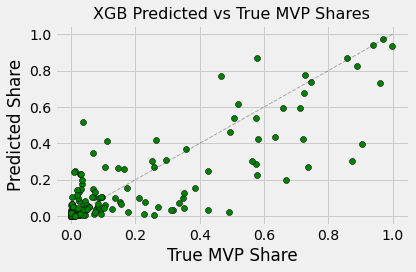

In [ ]:
plt.xlabel("True MVP Share")
plt.ylabel("Predicted Share")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.title('XGB Predicted vs True MVP Shares', fontsize=16)
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.3)
plt.scatter(y_test, y_xgb, edgecolor='k', color='g')
plt.tight_layout()

Getting Names/stats for Prediction Season

In [ ]:
df_to_predict = df_train_filtered_og.fillna(df_train_filtered_og.median())
df_to_predict = df_to_predict[df_to_predict['Season'] == 2011]

df_to_predict_names = df_to_predict.iloc[:, 0]
df_to_predict_ = df_to_predict[['ORB%', 'ORB', 'BLK%', 'FTr', 'Age', 'TOV%', '3P%', '3PAr', 'BLK', 'STL%', 'GS', 'TRB%',
                                              'STL', 'FG%', '3PA', 'DRB%', 'G', '3P', 'TRB', 'FT%', '2P%', 'AST', 'PF', 'MP',
                                              'eFG%', 'DRB', 'AST%', '2PA', 'TOV', 'TS%', '2P', 'FTA', 'FGA', 'USG%', 'DBPM', 'FT',
                                              'DWS', 'FG', 'PTS', 'Rk', 'OBPM', 'OWS', 'PER', 'BPM', 'WS/48', 'VORP', 'WS',
                                              'Wins', 'Losses', 'W/L%', 'GS%', 'GP%',
                                              'Dbert_sadness', 'Dbert_joy', 'Dbert_love','Dbert_anger', 'Dbert_fear', 'Dbert_surprise',
       'bert_others', 'bert_joy', 'bert_sadness', 'bert_anger',
       'bert_surprise', 'bert_disgust', 'bert_fear', 'bert_NEG',
       'bert_NEU', 'bert_POS']]

Making Model Predictions

In [ ]:
gbtreePredict =gbtree_model.predict(df_to_predict_)
gbtreePredict = gbtreePredict.tolist()

xgbPredict = xgb_model.predict(df_to_predict_)
xgbPredict = xgbPredict.tolist()

knnPredict = knn_model.predict(df_to_predict_)
knnPredict = knnPredict.tolist()

rfPredict = rf_model.predict(df_to_predict_)
rfPredict = rfPredict.tolist()
for (i, j) in zip(df_to_predict_names, xgbPredict):
    print(i, j)

Kobe Bryant 0.08975933492183685
Kevin Durant 0.06500229239463806
Manu Ginóbili 0.012479064986109734
Blake Griffin 0.0033749134745448828
Dwight Howard 0.08836021274328232
LeBron James 0.6181154251098633
Dirk Nowitzki 0.012998546473681927
Tony Parker 0.014171992428600788
Chris Paul 0.009026799350976944
Rajon Rondo 0.02396853268146515
Derrick Rose 0.4079411029815674
Amar'e Stoudemire 0.008942360989749432
Dwyane Wade 0.30195188522338867


Sorting Data for Plots

In [ ]:
gbtreeListUnsorted = [[i, j] for i, j in zip(df_to_predict_names, gbtreePredict)]
gbtreeDataUnsorted = [row[1] for row in gbtreeListUnsorted]
gbtreeList = sorted(gbtreeListUnsorted, key = itemgetter(1), reverse = True)

gbtreeData = [row[1] for row in gbtreeList]
gbtreeNames = [row[0] for row in gbtreeList]

knnListUnsorted = [[i, j] for i, j in zip(df_to_predict_names, knnPredict)]
knnDataUnsorted = [row[1] for row in knnListUnsorted]
knnList = sorted(knnListUnsorted, key = itemgetter(1), reverse = True)

knnData = [row[1] for row in knnList]
knnNames = [row[0] for row in knnList]

rfListUnsorted = [[i, j] for i, j in zip(df_to_predict_names, rfPredict)]
rfDataUnsorted = [row[1] for row in rfListUnsorted]
rfList = sorted(rfListUnsorted, key = itemgetter(1), reverse = True)

rfData = [row[1] for row in rfList]
rfNames = [row[0] for row in rfList]


xgbListUnsorted = [[i, j] for i, j in zip(df_to_predict_names, xgbPredict)]
xgbDataUnsorted = [row[1] for row in xgbListUnsorted]
xgbList = sorted(xgbListUnsorted, key = itemgetter(1), reverse = True)

xgbData = [row[1] for row in xgbList]
xgbNames = [row[0] for row in xgbList]

print(xgbList)

x_gbtree = np.arange(len(gbtreeData))
x_knn = np.arange(len(knnData))
x_rf = np.arange(len(rfData))
x_xgb = np.arange(len(xgbData))

[['LeBron James', 0.6181154251098633], ['Derrick Rose', 0.4079411029815674], ['Dwyane Wade', 0.30195188522338867], ['Kobe Bryant', 0.08975933492183685], ['Dwight Howard', 0.08836021274328232], ['Kevin Durant', 0.06500229239463806], ['Rajon Rondo', 0.02396853268146515], ['Tony Parker', 0.014171992428600788], ['Dirk Nowitzki', 0.012998546473681927], ['Manu Ginóbili', 0.012479064986109734], ['Chris Paul', 0.009026799350976944], ["Amar'e Stoudemire", 0.008942360989749432], ['Blake Griffin', 0.0033749134745448828]]


KNN Regressor needed some extra processing

In [ ]:
knnData = [item for sublist in knnData for item in sublist]
knnDataUnsorted = [item for sublist in knnDataUnsorted for item in sublist]


Plotting XGB Regressor Predictions (Best Performing Model)

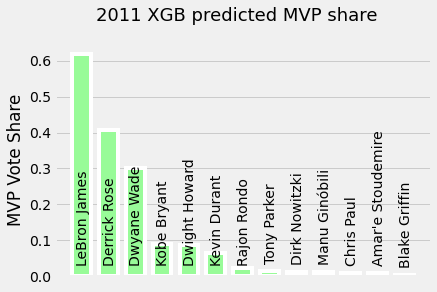

In [ ]:
plt.style.use('fivethirtyeight')

rf, ax = plt.subplots()
ax.bar(x_xgb, xgbData, width = .7, edgecolor = 'white', color = 'palegreen', linewidth = 4, label = 'Predicted')

labels = xgbNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 6:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 6:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
rf.suptitle("2011 XGB predicted MVP share", size = 18, y = 1.005)
ax.xaxis.set_visible(False)
ax.set_ylabel("MVP Vote Share")


Getting Average of All 4 Model Predictions

In [ ]:
avgPredict = []

for (i, j, h, k) in zip(rfDataUnsorted, knnDataUnsorted, xgbDataUnsorted, gbtreeDataUnsorted):
    avgPredict.append((i + j + h+ k) / 3)

avgList = [[i, j] for i, j in zip(df_to_predict_names, avgPredict)]
avgList = sorted(avgList, key = itemgetter(1), reverse = True)

avgData = [row[1] for row in avgList]
avgNames = [row[0] for row in avgList]
print(avgList)

x_avg = np.arange(len(avgData))

[['LeBron James', 0.718785312301874], ['Derrick Rose', 0.3814533014437671], ['Dwyane Wade', 0.3517759757284565], ['Dwight Howard', 0.24941772950387656], ['Kobe Bryant', 0.14687234620137213], ['Rajon Rondo', 0.14366077267342894], ['Dirk Nowitzki', 0.11868431016943683], ['Chris Paul', 0.09180110740439695], ['Kevin Durant', 0.0860192382635967], ['Manu Ginóbili', 0.05368526057363774], ['Tony Parker', 0.05219884456341523], ["Amar'e Stoudemire", 0.04360086335332967], ['Blake Griffin', 0.031152703242406734]]


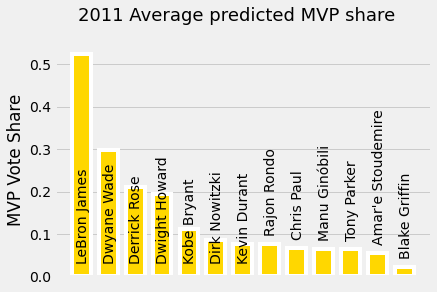

In [ ]:
plt.style.use('fivethirtyeight')

rf, ax = plt.subplots()
#palegreen, lightcoral
ax.bar(x_gbtree, gbtreeData, width = .7, edgecolor = 'white', color = 'gold', linewidth = 4, label = 'Predicted')

labels = gbtreeNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 6:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 6:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
rf.suptitle("2011 Average predicted MVP share", size = 18, y = 1.005)
ax.xaxis.set_visible(False)
ax.set_ylabel("MVP Vote Share")



rf.savefig('average_regressor_predicted_share_2011.png', dpi = 400, bbox_inches = 'tight')

Plotting Actual MVP Shares

In [ ]:
testseason = df_train_filtered_og.loc[df_train_filtered_og.Season == 2011]
realListUnsorted = [[i, j] for i, j in zip(df_to_predict_names, testseason.Share)]
realDataUnsorted = [row[1] for row in realListUnsorted]
realList = sorted(realListUnsorted, key = itemgetter(1), reverse = True)

realData = [row[1] for row in realList]
realNames = [row[0] for row in realList]

print(realList)

x_real = np.arange(len(realData))

[['Derrick Rose', 0.977], ['Dwight Howard', 0.531], ['LeBron James', 0.431], ['Kobe Bryant', 0.354], ['Kevin Durant', 0.157], ['Dirk Nowitzki', 0.09300000000000001], ['Dwyane Wade', 0.02], ['Manu Ginóbili', 0.017], ["Amar'e Stoudemire", 0.006999999999999999], ['Blake Griffin', 0.004], ['Rajon Rondo', 0.004], ['Tony Parker', 0.002], ['Chris Paul', 0.002]]


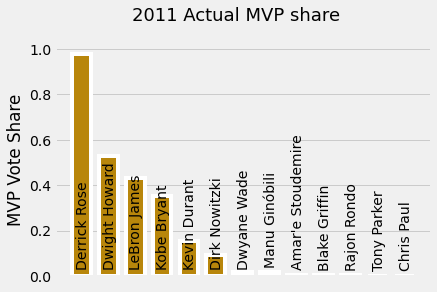

In [ ]:
plt.style.use('fivethirtyeight')

rf, ax = plt.subplots()
#palegreen, lightcoral
ax.bar(x_real, realData, width = .7, edgecolor = 'white', color = 'darkgoldenrod', linewidth = 4, label = 'Predicted')

labels = realNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 6:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 6:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
rf.suptitle("2011 Actual MVP share", size = 18, y = 1.005)
ax.xaxis.set_visible(False)
ax.set_ylabel("MVP Vote Share")



rf.savefig('actual_regressor_predicted_share_2011.png', dpi = 400, bbox_inches = 'tight')

Feature Importance for XGB Regressor

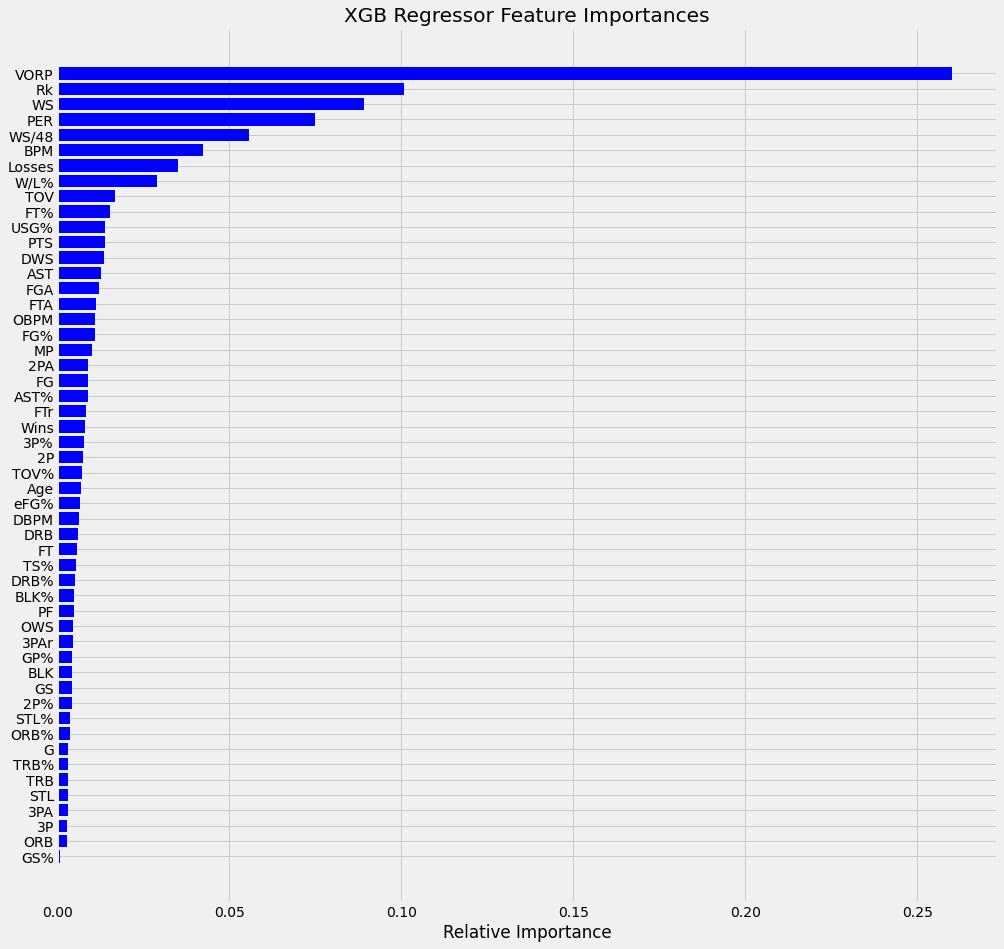

<Figure size 432x288 with 0 Axes>

In [ ]:
features =['ORB%', 'ORB', 'BLK%', 'FTr', 'Age', 'TOV%', '3P%', '3PAr', 'BLK', 'STL%', 'GS', 'TRB%',
                                              'STL', 'FG%', '3PA', 'DRB%', 'G', '3P', 'TRB', 'FT%', '2P%', 'AST', 'PF', 'MP',
                                              'eFG%', 'DRB', 'AST%', '2PA', 'TOV', 'TS%', '2P', 'FTA', 'FGA', 'USG%', 'DBPM', 'FT',
                                              'DWS', 'FG', 'PTS', 'Rk', 'OBPM', 'OWS', 'PER', 'BPM', 'WS/48', 'VORP', 'WS',
                                              'Wins', 'Losses', 'W/L%', 'GS%', 'GP%',
                                              'Dbert_sadness', 'Dbert_joy', 'Dbert_love','Dbert_anger', 'Dbert_fear', 'Dbert_surprise',
       'bert_others', 'bert_joy', 'bert_sadness', 'bert_anger',
       'bert_surprise', 'bert_disgust', 'bert_fear', 'bert_NEG',
       'bert_NEU', 'bert_POS']
importances = rf_model.feature_importances_
indices = np.argsort(importances)
fig = plt.figure(figsize=(15, 15))

plt.title('XGB Regressor Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
plt.savefig('xgb_feature_imp_regressor.png')